# Data Separation

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 21 October 2025  
Last updated: 21 October 2025

In [1]:
"""
Module providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.
"""

'\nModule providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.\n'

## Setup

### Packages

In [31]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# # import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

### Data

In [4]:
united_water = pd.read_parquet('data/clean/water.parquet')
united_soil = pd.read_parquet('data/clean/soil.parquet')

## Split

In [5]:
## Subset for testing
# water_mini = united_water['2010-01-01 00:00:00':'2012-12-31 23:59:59']
# water_mini = united_water.copy()
# water_mini
water_mini = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]
water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)
water_mini = water_mini.dropna()
water_mini

/var/folders/dr/4_7b2hbn60q7cynx4gmn5vhr0000gp/T/ipykernel_88900/1111001267.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)


,raw_ro,level_ro,ra_rain,obstruction_ro
datetime,,,,
1989-07-19 11:55:00,12.40,12.40,0.0,False
1989-07-19 12:00:00,12.40,12.40,0.0,False
1989-07-19 12:05:00,12.40,12.40,0.0,False
1989-07-19 12:10:00,12.50,12.50,0.0,False
1989-07-19 12:15:00,12.20,12.20,0.0,False
...,...,...,...,...
2025-08-01 12:40:00,60.00,60.00,0.0,False
2025-08-01 12:45:00,60.02,60.02,0.0,False
2025-08-01 12:50:00,59.65,59.65,0.0,False


In [6]:
# # soil_mini = united_soil[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# soil_mini = united_soil.copy()
# # soil_mini = soil_mini.reset_index()
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini['dup'] = soil_mini.duplicated()
# # print(len(soil_mini[soil_mini.duplicated()==False]))
# # print(len(soil_mini.drop_duplicates()))
# # # united_soil[united_soil['chk_note_shallow']=='doubtful']
# # # soil_mini['sample'] = soil_mini['sample'].astype('category')
# # # soil_mini = soil_mini[['sample', 'h2o_by_wet_shallow', 'h2o_by_wet_deep']]
# # # soil_mini

In [7]:
# water_mini = water_mini[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]
# water_mini

In [8]:
# len(soil_mini)

In [9]:
soil_mini_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
soil_mini_shallow = soil_mini_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

soil_mini_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
soil_mini_deep = soil_mini_deep.pivot(columns='sample', values='h2o_by_wet_deep')

soil_mini = pd.merge(
    soil_mini_shallow,
    soil_mini_deep,
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    suffixes = ("_shallow", "_deep"),
    how = "outer"
    )

soil_mini

sample,1_shallow,2_shallow,3_shallow,4_shallow,5_shallow,6_shallow,7_shallow,8_shallow,9_shallow,10_shallow,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
date,,,,,,,,,,,,,,,,,,,,
1989-06-23,35.4,40.4,35.3,37.1,41.0,35.2,44.5,44.6,33.2,32.3,36.1,37.1,35.5,35.1,39.1,32.2,35.3,30.2,32.0,29.9
1989-06-30,35.7,43.5,36.7,37.2,44.1,35.3,37.4,41.7,32.3,33.5,36.7,39.8,36.2,31.0,38.6,30.7,32.5,29.3,30.4,29.5
1989-07-06,36.5,44.1,37.1,37.7,43.8,35.5,44.5,44.0,33.3,31.7,35.8,39.6,31.1,34.5,39.8,34.5,34.9,32.2,32.2,29.6
1989-07-13,36.9,40.3,40.6,35.7,41.9,39.8,38.6,33.9,31.3,32.3,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-20,35.1,40.4,37.0,38.8,43.6,37.4,36.1,31.3,29.8,32.5,35.4,37.1,35.5,35.1,38.1,29.5,33.8,27.0,30.6,30.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02,43.0,41.8,51.0,37.9,38.3,38.9,47.5,35.6,33.2,27.4,38.8,34.6,44.7,43.6,39.5,37.0,31.4,29.3,26.3,27.8
2025-05-16,39.6,45.6,47.2,46.9,46.3,44.7,36.1,33.2,30.9,30.0,38.3,38.6,51.5,48.2,44.0,38.7,35.6,33.0,34.2,29.6
2025-05-28,40.6,37.7,44.6,39.8,44.2,46.5,46.3,49.7,36.4,32.7,38.1,36.1,43.3,33.2,38.8,46.4,37.5,33.2,30.9,30.3


### Unite

In [10]:
# water_mini_test = water_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']
# print(len(water_mini_test))
# soil_mini_test = soil_mini['1990-01-01 00:00:00':'1992-12-31 23:23:59']

In [11]:
data_united = pd.merge(
    water_mini,
    soil_mini,
    left_index=True,
    right_index=True,
    # soil_mini_shallow.reset_index(),
    # soil_mini_deep.reset_index(),
    # on = ["date", "sample"],
    # suffixes = ("_shallow", "_deep"),
    how = "outer"
    )

# mini_mini_test = mini_test['1992-04-09 00:00:00':'1992-04-09 23:23:59']
# mini_mini_test
# mini_test['soil_stale'] = 

cols_to_fill = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
data_united[cols_to_fill] = data_united[cols_to_fill].ffill()
data_united = data_united.dropna(subset='obstruction_ro')
data_united

,raw_ro,level_ro,ra_rain,obstruction_ro,1_shallow,2_shallow,3_shallow,4_shallow,5_shallow,6_shallow,...,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
1989-07-19 11:55:00,12.40,12.40,0.0,False,36.9,40.3,40.6,35.7,41.9,39.8,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:00:00,12.40,12.40,0.0,False,36.9,40.3,40.6,35.7,41.9,39.8,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:05:00,12.40,12.40,0.0,False,36.9,40.3,40.6,35.7,41.9,39.8,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:10:00,12.50,12.50,0.0,False,36.9,40.3,40.6,35.7,41.9,39.8,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
1989-07-19 12:15:00,12.20,12.20,0.0,False,36.9,40.3,40.6,35.7,41.9,39.8,...,33.3,37.6,36.0,33.2,37.8,30.4,33.5,26.9,30.7,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01 12:40:00,60.00,60.00,0.0,False,39.5,45.9,51.7,43.9,46.7,47.6,...,44.7,37.8,46.3,37.0,36.4,41.1,32.2,34.7,33.3,34.1
2025-08-01 12:45:00,60.02,60.02,0.0,False,39.5,45.9,51.7,43.9,46.7,47.6,...,44.7,37.8,46.3,37.0,36.4,41.1,32.2,34.7,33.3,34.1
2025-08-01 12:50:00,59.65,59.65,0.0,False,39.5,45.9,51.7,43.9,46.7,47.6,...,44.7,37.8,46.3,37.0,36.4,41.1,32.2,34.7,33.3,34.1
2025-08-01 12:55:00,59.65,59.65,0.0,False,39.5,45.9,51.7,43.9,46.7,47.6,...,44.7,37.8,46.3,37.0,36.4,41.1,32.2,34.7,33.3,34.1


### Train/Test (80/20)

In [12]:
# # mini_xy = water_mini[['level_ro', 'raw_ro', 'chk_note_ro', 'source_ro']].dropna()
# mini_xy = water_mini.copy().drop('level_ro', axis=1).dropna()
# mini_y = mini_xy['obstruction_ro']
# # mini_x = mini_xy[['raw_ro', 'chk_note_ro', 'source_ro']]
# mini_x = mini_xy.drop('obstruction_ro', axis=1)
# mini_xy

united_y = data_united['obstruction_ro']
united_x = data_united.drop('obstruction_ro', axis=1)

In [13]:
print("Test:\t20p of", len(united_y), "is", round(.2*len(united_y)))
print("Train:\t80p of", len(united_y), "is", round(.8*len(united_y)))
print(round(.2*len(united_y)) + round(.8*len(united_y)))

# mini_x.index[1]

Test:	20p of 3557020 is 711404
Train:	80p of 3557020 is 2845616
3557020


In [14]:
x_train, x_test, y_train, y_test = train_test_split(united_x, united_y, test_size = 0.2, shuffle=False)

print(
    "Train:\t", len(x_train), "\t", x_train.index[0], "thru", x_train.index[-1],
    "\nTest:\t", len(x_test), "\t\t", x_test.index[0], "thru", x_test.index[-1]
    # len(x_train), len(x_test), "\n",
    # x_train.index[-1]
)

Train:	 2845616 	 1989-07-19 11:55:00 thru 2018-10-27 09:20:00 
Test:	 711404 		 2018-10-27 09:25:00 thru 2025-08-01 13:00:00


### Sliding Window

In [15]:
tscv = TimeSeriesSplit(n_splits=25)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=25, test_size=None)


In [16]:
# print(tscv)
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    # print("  Train: index=", mini_x.index[train_index])
    # print(f"  Test:  index={val_index}")
    print("--------------------------------------------------")

del i, train_index, val_index

Fold 0:
  Train: index=[     0      1      2 ... 109463 109464 109465]
  Test:  index=[109466 109467 109468 ... 218909 218910 218911]
--------------------------------------------------
Fold 1:
  Train: index=[     0      1      2 ... 218909 218910 218911]
  Test:  index=[218912 218913 218914 ... 328355 328356 328357]
--------------------------------------------------
Fold 2:
  Train: index=[     0      1      2 ... 328355 328356 328357]
  Test:  index=[328358 328359 328360 ... 437801 437802 437803]
--------------------------------------------------
Fold 3:
  Train: index=[     0      1      2 ... 437801 437802 437803]
  Test:  index=[437804 437805 437806 ... 547247 547248 547249]
--------------------------------------------------
Fold 4:
  Train: index=[     0      1      2 ... 547247 547248 547249]
  Test:  index=[547250 547251 547252 ... 656693 656694 656695]
--------------------------------------------------
Fold 5:
  Train: index=[     0      1      2 ... 656693 656694 656695]
  Te

In [17]:
# tscv = TimeSeriesSplit(n_splits=15)

for train_index, val_index in tscv.split(x_train):
    x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
    model.fit(x_t, y_t)
    
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    # print("Validation RMSE:", mean_squared_error(y_val, preds, squared=False))
    print("Validation MSE:", mse, "\tRMSE:", np.sqrt(mse))

del x_t, X_val, y_t, y_val, model, preds, mse

Validation MSE: 0.014239986427128315 	RMSE: 0.11933141425093526
Validation MSE: 0.011904122307896614 	RMSE: 0.10910601407757785
Validation MSE: 0.019435981288552284 	RMSE: 0.13941298823478493
Validation MSE: 0.02048373967409134 	RMSE: 0.14312141584714477
Validation MSE: 0.014040423557162285 	RMSE: 0.11849229323952797
Validation MSE: 0.036566536873579025 	RMSE: 0.19122378741563253
Validation MSE: 0.018493831157684326 	RMSE: 0.13599202608125346
Validation MSE: 0.005290059372782707 	RMSE: 0.0727327943419109
Validation MSE: 0.011928034014999866 	RMSE: 0.10921553925609609
Validation MSE: 0.005628868471831083 	RMSE: 0.0750257853796352
Validation MSE: 0.005859961733222008 	RMSE: 0.07655038689139336
Validation MSE: 0.0032402861397713423 	RMSE: 0.056923511309223906
Validation MSE: 0.007968353107571602 	RMSE: 0.08926563228685272
Validation MSE: 0.014609077014029026 	RMSE: 0.1208680148510309
Validation MSE: 0.14264391362667084 	RMSE: 0.37768229191566666
Validation MSE: 0.05271444097161293 	RMSE: 

In [21]:
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    continue
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={val_index}")

# print(train_index, "\n", val_index)

x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
model.fit(x_t, y_t)

preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)

In [30]:
mini_val = y_val.copy()
mini_val = mini_val.reset_index()
mini_val['pred'] = preds
mini_val.set_index('index')
mini_val['pred_tf'] = np.where(mini_val['pred'] >= 0.5, True, False)
mini_val

,index,obstruction_ro,pred,pred_tf
0,2017-10-12 08:55:00,True,0.955051,True
1,2017-10-12 09:00:00,True,0.955051,True
2,2017-10-12 09:05:00,True,0.955051,True
3,2017-10-12 09:10:00,True,0.938064,True
4,2017-10-12 09:15:00,True,0.887598,True
...,...,...,...,...
109441,2018-10-27 09:00:00,False,0.011875,False
109442,2018-10-27 09:05:00,False,0.011875,False
109443,2018-10-27 09:10:00,False,0.305593,False
109444,2018-10-27 09:15:00,False,0.288772,False


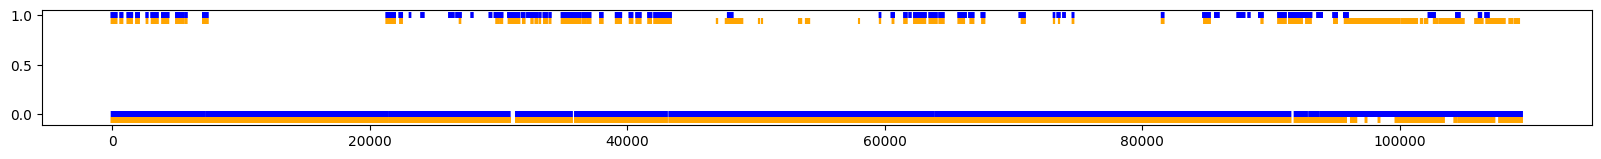

In [47]:
fig, ax = plt.subplots(figsize=(20, 1.5))
ax.scatter(mini_val.index, mini_val['obstruction_ro'], s=25, color='blue', marker="|")
ax.scatter(mini_val.index, mini_val['pred_tf']-.06, s=25, color='orange', marker="|")

plt.show()